<div style="border-bottom: 2px solid black; padding: 10px;">
    <h1 style="margin-bottom: 3px;">Machine Learning and business analytics</h1>
    <h3 style="margin-top: 0px; color: gray;">Sentiment analysis</h3>
    <p>Date: September 2, 2024</p>
</div>

- **Group:** Team Delta

## Sentiment analysis - Part 3 - Training

### Requirements

- Python 3.10.12
- pandas
- numpy
- matplotlib
- scikitlearn
- langdetect/langid
- nltk
- tensorflow

### Environment

#### Libraries

In [58]:
import pandas as pd
import numpy as np
import warnings
import csv
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import math
import langid
import nltk

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report

warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

#### Constants and environment variables

In [59]:
training_file_path = f'../dataset/index/df_training_indexed.csv'
test_file_path = f'../dataset/index/df_test_indexed.csv'

DISPLAY_MODEL_SUMMARY = False
# COLUMN_OF_INTEREST = 'text'
COLUMN_OF_INTEREST = 'index'


### Loading the dataset

We load the indexed files.

In [60]:
df_training_indexed = pd.read_csv(training_file_path, encoding='ISO-8859-1')
df_test_indexed = pd.read_csv(test_file_path, encoding='ISO-8859-1')

Check for attribute types:

In [61]:
df_training_indexed.dtypes

textID       object
text         object
sentiment    object
index        object
dtype: object

In [62]:
df_test_indexed.dtypes

textID       object
text         object
sentiment    object
index        object
dtype: object

### Machine learning

#### Encoding

Create a basic encoder:

In [63]:
label_encoder = LabelEncoder()

Convert the index and the sentiments to numpy arrays:

In [64]:
trainining_texts = df_training_indexed[COLUMN_OF_INTEREST].values

trainining_sentiments = df_training_indexed['sentiment'].values


test_texts = df_test_indexed[COLUMN_OF_INTEREST].values

test_sentiments = df_test_indexed['sentiment'].values


We train the encoder and map the sentiments to numbers (map sentiments to values 0, 1, 2):

In [65]:
trainining_sentiments_encoded = label_encoder.fit_transform(trainining_sentiments)

test_sentiments_encoded = label_encoder.transform(test_sentiments)

Project the data to training and testing arrays and labels for the neural network:

In [66]:
X_train = trainining_texts.astype(str)

Y_train = trainining_sentiments_encoded

X_test = test_texts.astype(str)

Y_test = test_sentiments_encoded

Verify the output:

In [67]:
print("Training - Total sentences    : ", len(X_train), '- before str: ', len(trainining_texts))
print("Training - Total sentiments   : ", len(Y_train))
print("Training - Discrete sentiments: ", np.unique(trainining_sentiments))
print("Training - Discrete labels    : ", np.unique(Y_train))
print("")
print("Testing  - Total sentences    : ", len(X_test))
print("Testing  - Total sentiments   : ", len(Y_test), '- before str: ', len(test_texts))
print("Testing  - Discrete sentiments: ", np.unique(test_sentiments))
print("Testing  - Discrete labels    : ", np.unique(test_sentiments_encoded))


Training - Total sentences    :  26319 - before str:  26319
Training - Total sentiments   :  26319
Training - Discrete sentiments:  ['negative' 'neutral' 'positive']
Training - Discrete labels    :  [0 1 2]

Testing  - Total sentences    :  3375
Testing  - Total sentiments   :  3375 - before str:  3375
Testing  - Discrete sentiments:  ['negative' 'neutral' 'positive']
Testing  - Discrete labels    :  [0 1 2]


#### Tokenization

In [68]:
tokenizer = Tokenizer(num_words=5000)

tokenizer.fit_on_texts(X_train)

vocabulary_size = len(tokenizer.word_index) + 1

print("Vocabulary Size:", vocabulary_size)

Vocabulary Size: 23450


#### Sequence generation

Generate the sequences:

In [69]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)

X_test_sequences = tokenizer.texts_to_sequences(X_test)

Analyse and find the maximum sequence length:

In [70]:
text_lengths = df_training_indexed['index'].apply(lambda x: len(str(x).split()))  # Or use another tokenization method

print(text_lengths.describe())

count    26319.000000
mean         6.896197
std          3.611429
min          1.000000
25%          4.000000
50%          6.000000
75%         10.000000
max         22.000000
Name: index, dtype: float64


In [71]:
max_sequence_length = int(text_lengths.quantile(0.95))

Length distribution:

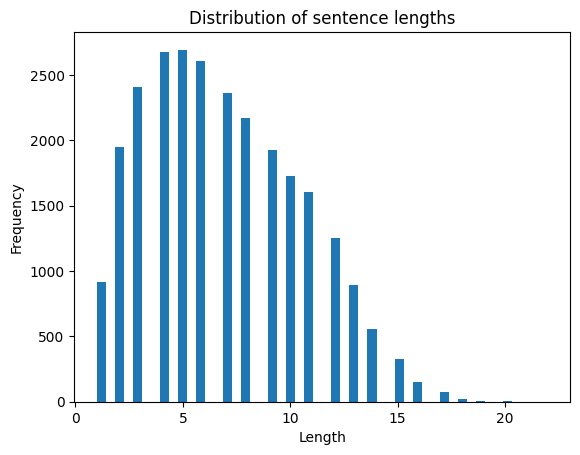

In [72]:
import matplotlib.pyplot as plt

plt.hist(text_lengths, bins=50)
plt.title('Distribution of sentence lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

Pad so that all vectors have the same dimensions:

In [73]:
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)

X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

#### Vectorization

Conver the output to vectors.

In [74]:
y_train_encoded = to_categorical(Y_train, num_classes=3)

y_test_encoded = to_categorical(Y_test, num_classes=3)

#### Build the neural network

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, LSTM, GlobalMaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

def buildModel(lstm_neurons = 64, embeddings_output_dimensions = 50, layers=2, neurons=[128, 32], drop_out = 0.3 ):
    model = Sequential([
        Embedding(input_dim=vocabulary_size, output_dim=embeddings_output_dimensions, input_length=max_sequence_length),
        LSTM(lstm_neurons, return_sequences=True),
        GlobalMaxPooling1D()])

    for i in range(layers):
        model.add(Dense(neurons[i], activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dropout(drop_out))

    model.add(Dense(3, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


#### Hyper parameter tuning

In [76]:
print(X_train_padded.shape)
print(y_train_encoded.shape)
print(X_test_padded.shape)
print(y_test_encoded.shape)

(26319, 13)
(26319, 3)
(3375, 13)
(3375, 3)


In [78]:
best_model = None
best_val_accuracy = 0
best_hyperparams = {}
best_history = None

epoch_options = [5, 10]
lstm_neurons_options = [32, 64, 128]
layers_options = [1, 2, 3]
neurons_options = [[32], [128, 32], [128, 64, 32]]
drop_out_options = [0.2]
learning_rate_options = [0.001]
embeddings_output_dimension_options = [50]
batch_size_options = [32]

total_networks = (len(epoch_options) *
                  len(lstm_neurons_options) *
                   len(layers_options) *
                   len(neurons_options) *
                   len(drop_out_options) *
                   len(learning_rate_options) *
                   len(embeddings_output_dimension_options) *
                   len(batch_size_options))

print("Total networks: ", total_networks)

iteration = 0

for epochs in epoch_options:
    for lstm_neurons in lstm_neurons_options:
        for layers in layers_options:
            for neurons in neurons_options:
                if len(neurons) != layers:
                    continue
                for drop_out in drop_out_options:
                    for learning_rate in learning_rate_options:
                        for embeddings_output_dimensions in embeddings_output_dimension_options:
                            for batch_size in batch_size_options:
                                iteration = iteration + 1

                                print(f'Network {iteration } of {total_networks} - Tuning with lstm_neurons={lstm_neurons}, layers={layers}, neurons={neurons}, drop_out={drop_out}, learning_rate={learning_rate}, embeddings_output_dimensions={embeddings_output_dimensions}, batch_size={batch_size}')

                                model = buildModel(lstm_neurons=lstm_neurons,
                                                    embeddings_output_dimensions=embeddings_output_dimensions,
                                                    layers=layers,
                                                    neurons=neurons,
                                                    drop_out=drop_out)

                                early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
                                history = model.fit(X_train_padded, y_train_encoded,
                                                    epochs=epochs,
                                                    batch_size=batch_size,
                                                    validation_data=(X_test_padded, y_test_encoded),
                                                    callbacks=[early_stopping],
                                                    verbose=0)

                                val_accuracy = np.max(history.history['val_accuracy'])

                                if val_accuracy > best.val_accuracy:
                                    best_val_accuracy = val_accuracy
                                    best_model = model
                                    best_hyperparams = {
                                        'lstm_neurons': lstm_neurons,
                                        'layers': layers,
                                        'neurons': neurons,
                                        'drop_out': drop_out,
                                        'learning_rate': learning_rate,
                                        'embeddings_output_dimensions': embeddings_output_dimensions,
                                        'batch_size': batch_size
                                    }
                                    best_history = history

                                    print("Improvement detected")

print("Best Model Found!")
print(f"Validation Accuracy: {best_val_accuracy}")
print(f"Best Hyperparameters: {best_hyperparams}")

Total networks:  54
Network 1 of 54 - Tuning with lstm_neurons=32, layers=1, neurons=[32], drop_out=0.2, learning_rate=0.001, embeddings_output_dimensions=50, batch_size=32


c:\Users\Vaso\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


NameError: name 'best' is not defined

In [ ]:
best_model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_31 (Embedding)        │ (None, 13, 50)         │     1,172,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 13, 64)         │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_31         │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,643,463 (13.90 MB)

 Trainable params: 1,214,487 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,428,976 (9.27 MB)

#### Learning progress for best model

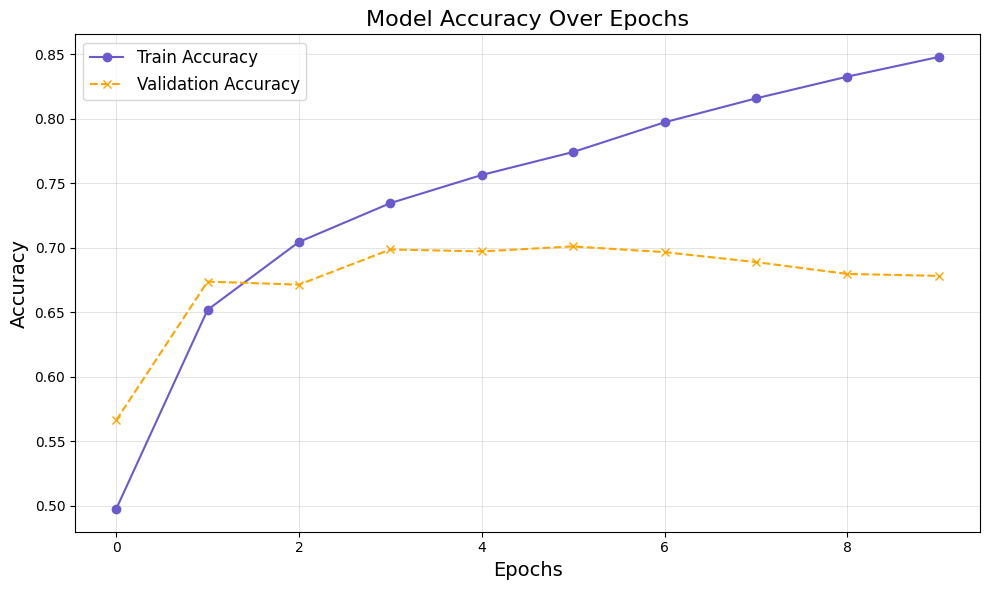

In [ ]:
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy', color='slateblue', linestyle='-', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--', marker='x')

plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.grid(True)
plt.legend(loc='best', fontsize=12)

plt.tight_layout()
plt.show()

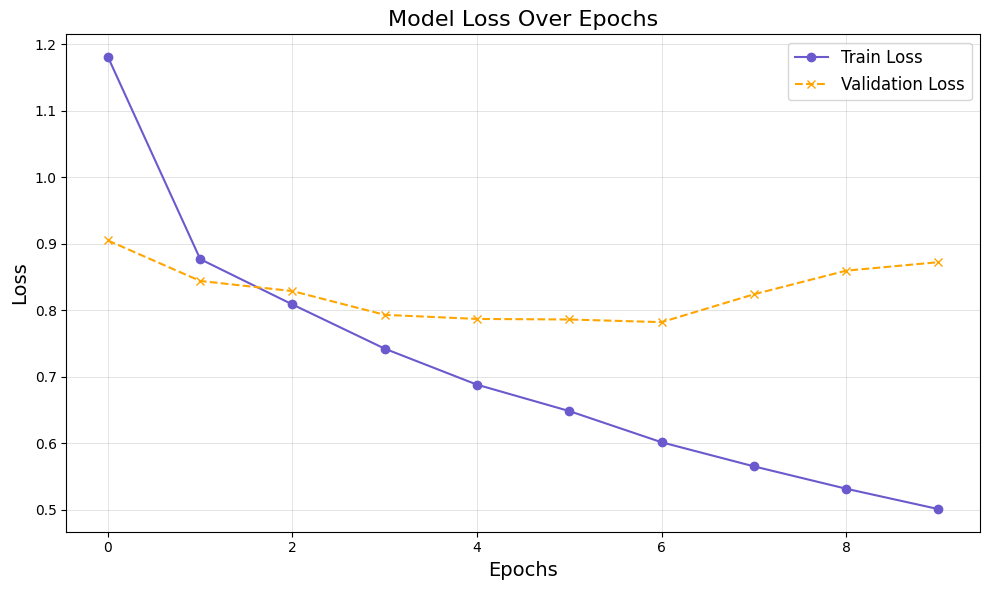

In [ ]:
plt.figure(figsize=(10, 6))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss', color='slateblue', linestyle='-', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--', marker='x')

plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.grid(True)
plt.legend(loc='best', fontsize=12)

plt.tight_layout()
plt.show()

#### Evaluation

In [ ]:
y_pred_prob = best_model.predict(X_test_padded)

y_pred = np.argmax(y_pred_prob, axis=1)

y_test_classes = np.argmax(y_test_encoded, axis=1)

print(classification_report(y_test_classes, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

     Class 0       0.78      0.64      0.71       955
     Class 1       0.67      0.74      0.71      1371
     Class 2       0.76      0.79      0.77      1049

    accuracy                           0.73      3375
   macro avg       0.74      0.72      0.73      3375
weighted avg       0.73      0.73      0.73      3375

